## Counting mentions of Wikipedia articles in Reddit submission titles

### Prerequisites

1. Download a dump of Wikipedia's articles, named `enwiki-{date_string}-pages-articles-multistream.xml.bz2`
2. Download the `enwiki-{date_string}-pages-articles-multistream-index.txt.bz2` file
3. Move those files into the same folder, removing the `enwiki-{date_string}` prefix
4. Process the `xml.bz2` file into a Parquet file using `wikiplain.load_bz2`
5. Run `PageRank.ipynb`

In [2]:
import asyncio
import glob
import gzip
import io
import itertools
import json
import math
import operator
import os
import pickle
import random
import re
import shutil
import socket
import struct
import subprocess
import sys
import tarfile
import time
from collections import ChainMap, defaultdict, deque
from contextlib import asynccontextmanager, contextmanager
from dataclasses import dataclass
from datetime import datetime
from enum import Enum, auto
from functools import lru_cache, partial
from urllib.parse import urlencode, urlsplit, quote as urlquote, unquote as urlunquote
from xml.sax.saxutils import unescape as xml_unescape
from typing import Any, Awaitable, Callable, Literal, TypeVar

import httpx
import ijson
import matplotlib.pyplot as plt
import mmh3
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import polars as pl
import seaborn as sns
import sqlalchemy as sa
import scipy.sparse
import toolz
from dotenv import load_dotenv
from ipywidgets import interact
from spacy.lang.en import English
from sqlalchemy import create_engine
from sqlalchemy.sql import column as sqlcolumn, select, text as sqltext
from tqdm.auto import tqdm
from zstandard import ZstdDecompressor, ZstdDecompressionReader
from arsenal.datastructures.unionfind import UnionFind
from arsenal.datastructures.heap import MinMaxHeap

import wikiplain
from special_cases import SECOND_LEVEL_DOMAINS
from nbhelpers.polars import pager, searcher
from umbc_web.process_possf2 import PENN_TAGS, PENN_TAGS_BY_ID

In [3]:
load_dotenv()

True

In [4]:
pl.Config.set_fmt_str_lengths(160)

polars.config.Config

In [85]:
class RedditRankFiles:
    def __init__(self, date_string):
        self.date_string = date_string
        self.enwiki_dir = f"{os.environ['ENWIKI_DIR']}/{date_string}"
        self.parquet_dir = os.environ.get('ENWIKI_PARQUET_DIR', self.enwiki_dir)
        self.reddit_dir = f"{os.environ['REDDIT_DIR']}"
        try:
            os.mkdir(f"{self.enwiki_dir}/pagerank")
        except FileExistsError:
            pass
    
    @property
    def enwiki_parquet_filename(self):
        return f"{self.parquet_dir}/enwiki_{self.date_string}.parquet"
    
    @property
    def pagerank_parquet_filename(self):
        return f"{self.parquet_dir}/enwiki_{self.date_string}_pagerank.parquet"
    
    @property
    def redditrank_parquet_filename(self):
        return f"{self.parquet_dir}/enwiki_{self.date_string}_redditrank.parquet"
    
    @property
    def enwiki_tokenized_database_uri(self):
        return f"sqlite:///{self.parquet_dir}/enwiki_tokenized_{self.date_string}.sqlite"

    @property
    def nub_filename(self):
        return f"{self.enwiki_dir}/pagerank/nub.pkl"
    
    @property
    def id_maps_filename(self):
        return f"{self.enwiki_dir}/pagerank/id_maps.pkl"
    
    @property
    def dense_id_arr_filename(self):
        return f"{self.enwiki_dir}/pagerank/dense_id_arr.pkl"
    
    @property
    def disambig_arr_filename(self):
        return f"{self.enwiki_dir}/pagerank/disambig_arr.pkl"
    
    @property
    def top_cite_domains_filename(self):
        return f"{self.enwiki_dir}/pagerank/top_cite_domains.pkl"
    
    @property
    def in_degree_filename(self):
        return f"{self.enwiki_dir}/pagerank/in_degree.pkl"
    
    @property
    def out_degree_filename(self):
        return f"{self.enwiki_dir}/pagerank/out_degree.pkl"

    def edge_filenames(self, num_partitions):
        return [
            f"{self.enwiki_dir}/pagerank/edges_{i}.pkl"
            for i in range(num_partitions)
        ]
    
    @property
    def reddit_relevance_filename_pattern(self):
        return f"{self.enwiki_dir}/pagerank/RS_*.pkl"
    
    def adjacency_filename(self, partition):
        return f"{self.enwiki_dir}/pagerank/adjacency_{partition}.npz"
    
    def adjacency_filenames(self, num_partitions):
        return [self.adjacency_filename(i) for i in range(num_partitions)]

In [86]:
files = RedditRankFiles("20230301")

### Re-use outputs computed by PageRank.ipynb

1. Pages with the same title
2. `id_map` from non-redirecting article titles to node number, and `id_map2` from redirecting article titles to node number

In [14]:
pqf = pq.ParquetFile(files.enwiki_parquet_filename)

In [7]:
with open(files.nub_filename, "rb") as fp:
    overwritten, pqf_size = pickle.load(fp)
with open(files.id_maps_filename, "rb") as fp:
    id_map, id_map2 = pickle.load(fp)

### Wikipedia article stats

1. Create `disambig_arr`, a simple boolean array recording whether each article is a disambiguation or set-index page.
2. Create `top_cite_domains`, the 1024 most commonly cited websites across all articles.

In [8]:
LOG_PARTITION_SIZE = 16
PARTITION_SIZE = 1 << LOG_PARTITION_SIZE
N = len(id_map)
NUM_PARTITIONS = math.ceil(N / PARTITION_SIZE)

In [9]:
class Vec:
    def __init__(self, dtype):
        self.array = np.ndarray((1024,), dtype=dtype)
        self.length = 0
    
    @property
    def capacity(self):
        return self.array.shape[0]

    def append(self, v):
        idx = self.length
        if idx >= self.capacity:
            addsz = max(2, self.capacity)
            self.array = np.hstack((self.array, np.zeros((addsz,), dtype=self.array.dtype)))
        self.array[idx] = v
        self.length += 1

In [10]:
def get_disambig_arr():
    iterator = tqdm(pqf.iter_batches(batch_size=100), total=math.ceil(pqf_size / 100))
    iterator = map(
        lambda b: zip(
            b["id"].to_numpy(),
            b["ns"].to_numpy(),
            map(operator.attrgetter("is_valid"), b["redirect"]),
            b["text"].to_pylist()
        ),
        iterator
    )
    iterator = itertools.chain.from_iterable(iterator)
    iterator = filter(lambda e: not e[2] and e[1] == 0 and e[0] not in overwritten, iterator)
    iterator = enumerate(map(operator.itemgetter(3), iterator))
    disambig_arr = np.zeros(N, dtype=np.bool_)
    for node_id, text in iterator:
        disambig_arr[node_id] = wikiplain.is_disambiguation_page(text)
    return disambig_arr

try:
    with open(files.disambig_arr_filename, "rb") as fp:
        disambig_arr = pickle.load(fp)
except Exception:
    disambig_arr = get_disambig_arr()
    with open(files.disambig_arr_filename, "wb") as fp:
        pickle.dump(disambig_arr, fp)

In [11]:
!curl https://raw.githubusercontent.com/timvieira/arsenal/master/arsenal/datastructures/heap/heap.pyx

# cython: language_level=3, boundscheck=False, infer_types=True, nonecheck=False
# cython: overflowcheck=False, initializedcheck=False, wraparound=False, cdivision=True

"""
Heap data structures with optional
 - Locators
 - Top-k (Bounded heap)

"""
import numpy as np

Vt = np.double
cdef double NaN = np.nan

# TODO: Use the C++ standard library's implementation of a vector of doubles.
cdef class Vector:

    cdef public:
        int cap
        int end
        double[:] val

    def __init__(self, cap):
        self.cap = cap
        self.val = np.zeros(self.cap, dtype=Vt)
        self.end = 0

    cpdef int push(self, double x):
        i = self.end
        self.ensure_size(i)
        self.val[i] = x
        self.end += 1
        return i

    cpdef object pop(self):
        "pop from the end"
        assert 0 < self.end
        self.end -= 1
        v = self.val[self.end]
        self.val[self.end] = NaN
        return v

    cdef void grow(self):
        self.cap *= 2
        new =

In [12]:
def get_top_cite_domains():
    iterator = tqdm(pqf.iter_batches(batch_size=100), total=math.ceil(pqf_size / 100))
    iterator = map(
        lambda b: zip(
            b["id"].to_numpy(),
            b["ns"].to_numpy(),
            map(operator.attrgetter("is_valid"), b["redirect"]),
            b["text"].to_pylist()
        ),
        iterator
    )
    iterator = itertools.chain.from_iterable(iterator)
    iterator = filter(lambda e: not e[2] and e[1] == 0 and e[0] not in overwritten, iterator)
    iterator = enumerate(map(operator.itemgetter(3), iterator))
    heap = MinMaxHeap()
    heap_limit = 256 * 1024
    for node_id, text in iterator:
        if (node_id + 1) % 750000 == 0:
            heap_limit /= 2
            while len(heap) > heap_limit:
                heap.popmin()
        page = defaultdict(int)
        for url in wikiplain.get_cite_urls(text):
            full_domain = re.sub(r"[:/].*", "", url)
            parts = full_domain.split('.')
            if len(parts) >= 2:
                site_domain = parts[-2] + '.' + parts[-1]
                if site_domain in SECOND_LEVEL_DOMAINS:
                    if len(parts) >= 3:
                        site_domain = parts[-3] + '.' + site_domain
                    else:
                        continue
                page[site_domain] += 1
        for k, v in page.items():
            if k in heap:
                heap[k] = heap.max[k] + v
            elif len(heap) < heap_limit:
                heap[k] = v
            elif v > heap.peekmin()[1]:
                heap.popmin()
                heap[k] = v
    top_cite_domains = []
    while len(heap) > 0:
        top_cite_domains.append(heap.popmax())
    return top_cite_domains

try:
    with open(files.top_cite_domains_filename, "rb") as fp:
        top_cite_domains = pickle.load(fp)
except Exception:
    top_cite_domains = get_top_cite_domains()
    with open(files.top_cite_domains_filename, "wb") as fp:
        pickle.dump(top_cite_domains, fp)

In [13]:
pager(pl.DataFrame(top_cite_domains, schema=['domain', 'count']), 16)

interactive(children=(Dropdown(description='page', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

<function nbhelpers.polars.pager.<locals>.<lambda>(page)>

In [14]:
searcher(pl.DataFrame(top_cite_domains, schema=['domain', 'count'])
          .with_columns(pl.Series("rank", range(len(top_cite_domains)))),
         ["domain"],
         16)

interactive(children=(Text(value='', description='q'), Output()), _dom_classes=('widget-interact',))

<function nbhelpers.polars.searcher.<locals>.searcher_run(q)>

In [15]:
excluded_domains = {"imgur.com", "twitter.com", "youtube.com", "soundcloud.com",
                    "instagram.com", "amazon.com", "github.com", "vimeo.com",
                    "google.com"
                   }
top_cite_domain_set = {domain for domain, _ in top_cite_domains} - excluded_domains

In [16]:
localsizes = (pl.DataFrame([(id(value), name, sys.getsizeof(value)) for name, value in locals().items()],
                          schema=['id', 'name', 'size'])
              .groupby('id')
              .agg(pl.max("size"), pl.col("name").apply(lambda ser: ser.to_list()))
              .sort('size', descending=True)
              .head(50)
             )
localsizes

id,size,name
i64,i64,list[str]
140211375397440,335544408,"[""id_map2""]"
140211375398208,335544408,"[""id_map""]"
140207182210752,65752,"[""top_cite_domain_set""]"
140211378105344,65752,"[""SECOND_LEVEL_DOMAINS""]"
140207177664384,9304,"[""top_cite_domains""]"
94105488649712,2043,"[""_i12""]"
94102624428736,1978,"[""_i4""]"
94102523582544,1562,"[""_i1""]"
140211378479168,1176,"[""PENN_TAGS""]"


In [17]:
pqf.close()

In [18]:
@lru_cache(maxsize=1)
def load_edges(partition):
    with open(files.edge_filenames(NUM_PARTITIONS)[partition], "rb") as fp:
        return pickle.load(fp)

### Create SQLite database for token-string to Wikipedia article map

- Occurrence of a normal article title: weight = 2
- Occurrence of a title redirecting to a normal article: weight = 1
- Occurrence of a disambiguation article title: weight = 1 distributed to all articles linked from that page

#### Edge format (copied from PageRank)

- `edges_{n}.pkl` stores the outgoing links from `PARITION_SIZE*n ..< PARTITION_SIZE*(n+1)`
- These are stored in a list where element `i` contains the links out to `PARITION_SIZE*i ..< PARTITION_SIZE*(i+1)`

In [19]:
nlp = English()

In [39]:
PR = pl.read_parquet(files.pagerank_parquet_filename)
PR_value = PR["value"].to_numpy()

In [21]:
engine = create_engine(files.enwiki_tokenized_database_uri)

In [ ]:
max_span_map = {}
with engine.begin() as conn:
    conn.execute(sqltext("CREATE TABLE term_map (term TEXT NOT NULL, id INTEGER NOT NULL, weight FLOAT NOT NULL)"))
    stmt = sqltext("INSERT INTO term_map (term, id, weight) VALUES (:term, :id, :weight)")
    iterator = itertools.chain(
        zip(id_map.items(), itertools.repeat(2.0)),
        zip(id_map2.items(), itertools.repeat(2.0)),
    )
    for (title, node_id), weight in tqdm(iterator, total=len(id_map) + len(id_map2)):
        parts = [token.norm_ for token in nlp.tokenizer(title) if not (token.is_left_punct or token.is_right_punct)]
        if len(parts) == 0:
            continue
        if len(parts) > max_span_map.get(parts[0], -1):
            max_span_map[parts[0]] = len(parts)
        term = " ".join(parts)
        if disambig_arr[node_id]:
            partition = node_id >> LOG_PARTITION_SIZE
            destinations = []
            for pair_tbl in load_edges(partition):
                destinations.append(pair_tbl[pair_tbl[:, 0] == node_id][:, 1])
            destination_arr = np.unique(np.hstack(destinations))
            pr_value_total = PR_value[destination_arr].sum()
            for dest_id in destination_arr.tolist():
                conn.execute(stmt, {"term": term, "id": dest_id, "weight": PR_value[dest_id] / pr_value_total})
        else:
            term = " ".join(token.norm_ for token in nlp.tokenizer(title))
            conn.execute(stmt, {"term": term, "id": node_id, "weight": weight})

  0%|          | 0/17034277 [00:00<?, ?it/s]

In [ ]:
with engine.begin() as conn:
    conn.execute(sqltext("CREATE TABLE term_map_2 AS SELECT term, id, MAX(weight) AS weight FROM term_map GROUP BY term, id"))
    conn.execute(sqltext("DROP TABLE term_map"))
    conn.execute(sqltext("ALTER TABLE term_map_2 RENAME TO term_map"))

In [ ]:
with engine.begin() as conn:
    conn.execute(sqltext("CREATE INDEX ix_term_map_term ON term_map (term)"))
    conn.execute(sqltext("CREATE TABLE max_span_map (k TEXT NOT NULL, v INTEGER NOT NULL)"))
    stmt = sqltext("INSERT INTO max_span_map (k, v) VALUES (:k, :v)")
    for k, v in max_span_map.items():
        conn.execute(stmt, {"k": k, "v": v})

### Evaluate reddit rank

1. Train `services/pos_tagger` on the UMBC web dataset
    ```bash
    python umbc_web/process_possf2.py /path/to/umbc_web/webbase_all

    # in services/pos_tagger
    cargo build --release
    ./target/release/pos_tagger <PORT> /path/to/write/model.json

    find /path/to/umbc_web/webbase_all -name \*.ldjson |
        shuf |
        { while read F; do
          stat -c %s "$F";
          python -c 'import struct,sys; sys.stdout.buffer.write(struct.pack(">2I", int(input()), 1)';
          cat "$F";
        } |
        nc localhost <PORT>
    ```

2. If exited, start `services/pos_tagger` again with the same model JSON path
3. Run the multiprocess `eval_reddit_rank.py` with the following command line args

In [ ]:
POS_TAGGER_PORT = 31323
print(files.enwiki_tokenized_database_uri, "\\")
print(len(id_map), "\\")
print(POS_TAGGER_PORT, "\\")
print(files.enwiki_dir)

In [24]:
summary_included = np.zeros(N, dtype=np.bool_)
relevance = np.zeros(N)
rel_files = glob.glob(files.reddit_relevance_filename_pattern)
for idx, filename in enumerate(sorted(rel_files)):
    with open(filename, "rb") as fp:
        relevance += pickle.load(fp)
    if (len(rel_files) - 1 - idx) % 3 == 0:
        ranks = np.zeros(N, dtype=np.int32)
        ranks[np.argsort(relevance)] = N - np.arange(N)
        summary_included |= ranks <= 10000
        relevance[:] = 0.0

In [25]:
summary_index = np.where(summary_included, np.cumsum(summary_included) - 1, -1)

In [26]:
summary_index

array([ 0, -1,  1, ..., -1, -1, -1])

In [27]:
summary_included.sum()

65936

In [43]:
summary_ranks = np.zeros((summary_included.sum(), 0))
date_ser = []
relevance = np.zeros(N)
relevance_3m = np.zeros(N)
for idx, filename in enumerate(sorted(glob.glob(files.reddit_relevance_filename_pattern))):
    with open(filename, "rb") as fp:
        arr = pickle.load(fp)
        relevance += arr
        relevance_3m += arr
    if (len(rel_files) - 1 - idx) % 3 == 0:
        year_month = re.search(r"RS_([0-9]{4}-[0-9]{2})", filename).group(1)
        date_ser.append(np.datetime64(year_month + '-01T00:00:00'))
        ranks = np.zeros(N, dtype=np.int32)
        ranks[np.argsort(relevance_3m)] = N - np.arange(N)
        summary_ranks = np.hstack((summary_ranks, ranks[summary_included, np.newaxis]))
        relevance_3m[:] = 0.0

In [44]:
%reset -f out

Flushing output cache (4 entries)


In [31]:
time_points = len(date_ser)

In [32]:
%matplotlib inline

In [66]:
%config InlineBackend.figure_formats = ['png']

In [34]:
sns.set_theme()
sns.set_context("paper")

In [51]:
def resolve_summary_ids(chart_keys_q):
    chart_keys = []
    chart_ids = []
    for k in chart_keys_q:
        if k not in id_map:
            print("Not found:", k)
            continue
        summary_id = summary_index[id_map[k]]
        if summary_id == -1:
            print("Outside top 10K:", k)
            continue
        chart_keys.append(k)
        chart_ids.append(summary_id)
    return chart_keys, chart_ids

def show_chart(query):
    chart_keys_q = query.split('|')
    chart_keys, chart_ids = resolve_summary_ids(chart_keys_q)
    if len(chart_ids) == 0:
        return
    chart_summary = summary_ranks[chart_ids]
    fig, ax = plt.subplots(figsize=(11, 6))
    sns.lineplot(x=np.repeat([date_ser], chart_summary.shape[0], axis=0).flatten(),
                 y=chart_summary.flatten(),
                 hue=np.repeat(np.array(chart_keys), time_points),
                 legend="full",
                 ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.yscale('log')
    ax.set_ylim([1, 100000])
    ax.invert_yaxis()

def show_comparison_chart(query):
    chart_keys_q = query.split('|')
    chart_keys, chart_ids = resolve_summary_ids(chart_keys_q)
    if len(chart_ids) == 0:
        return
    chart_summary = summary_ranks[chart_ids]
    chart_ranks = np.zeros_like(chart_summary, dtype=np.int64)
    np.put_along_axis(chart_ranks,
                      chart_summary.argsort(axis=0),
                      1 + np.repeat(np.arange(chart_summary.shape[0])[:, np.newaxis], time_points, axis=1),
                      0)
    fig, ax = plt.subplots(figsize=(11, 3))
    ax = sns.lineplot(x=np.repeat([date_ser], chart_summary.shape[0], axis=0).flatten(),
                      y=chart_ranks.flatten(),
                      hue=np.repeat(np.array(chart_keys), time_points),
                      legend="full",
                      ax=ax,
                      linewidth=3)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_yticks(np.arange(1, chart_summary.shape[0] + 1, dtype=int))
    ax.invert_yaxis()

In [35]:
interact(show_chart, query="")

interactive(children=(Text(value='', description='query'), Output()), _dom_classes=('widget-interact',))

<function __main__.show_chart(query)>

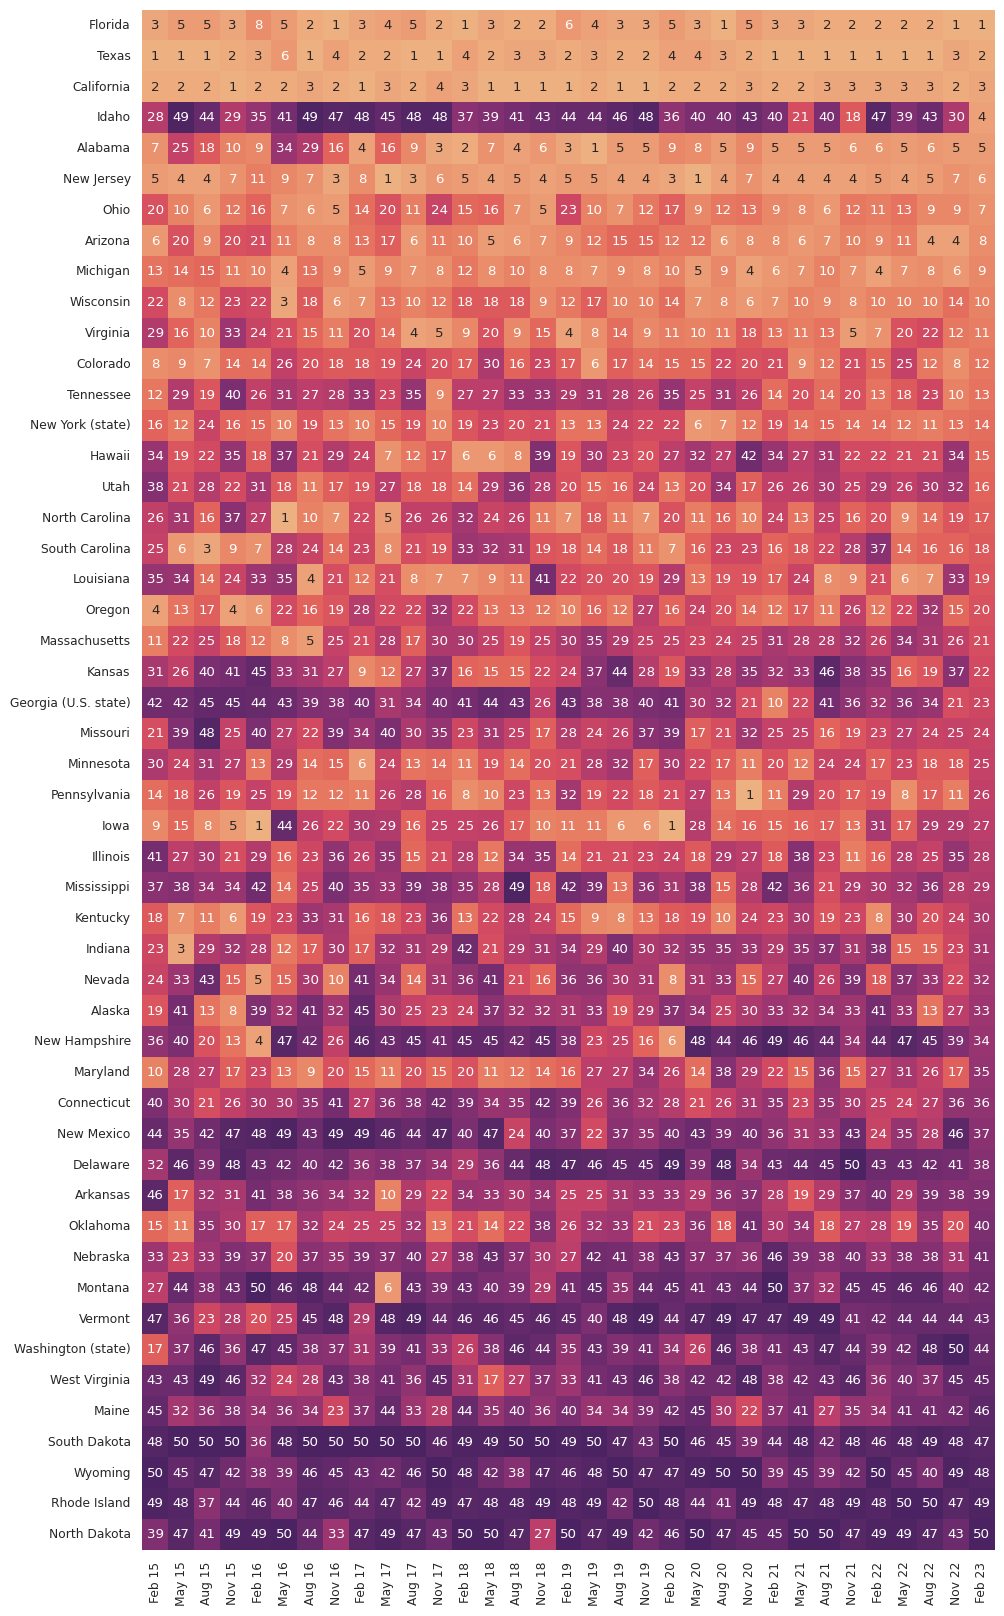

In [104]:
chart_keys, chart_ids = resolve_summary_ids([
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
    'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia (U.S. state)',
    'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
    'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
    'New Mexico', 'New York (state)', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
    'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington (state)', 'West Virginia', 'Wisconsin', 'Wyoming',
])
chart_summary = summary_ranks[chart_ids]
chart_ranks = np.zeros_like(chart_summary, dtype=np.int64)
np.put_along_axis(chart_ranks,
                  chart_summary.argsort(axis=0),
                  1 + np.repeat(np.arange(chart_summary.shape[0])[:, np.newaxis], time_points, axis=1),
                  0)
chart_summary_order = chart_ranks[:, -1].argsort()
chart_ranks = chart_ranks[chart_summary_order]
chart_keys = np.array(chart_keys)[chart_summary_order].tolist()
fig, ax = plt.subplots(figsize=(11, 20))
ax = sns.heatmap(chart_ranks,
                 xticklabels=[dt.astype(datetime).strftime("%b %y") for dt in date_ser],
                 yticklabels=chart_keys,
                 ax=ax,
                 cmap='flare',
                 cbar=False,
                 annot=True)

In [50]:
pager(PR.with_columns(pl.Series("relevance", relevance)).filter(pl.col("relevance") > 0).sort("relevance", descending=True), 20)

interactive(children=(IntSlider(value=17942, description='page', max=35884), Output()), _dom_classes=('widget-…

<function nbhelpers.polars.pager.<locals>.<lambda>(page)>

In [83]:
with open(files.in_degree_filename, "rb") as fp:
    in_degree = pickle.load(fp)
with open(files.out_degree_filename, "rb") as fp:
    out_degree = pickle.load(fp)

In [82]:
def perplexity(distribution):
    return np.power(2, np.sum(-distribution * np.log2(distribution)))

def personalized_page_rank(preference, threshold=1, random_jump_prob=0.15):
    global files
    global N
    global in_degree
    global out_degree
    current_rank = np.ones(N, dtype=np.float64) / N
    next_rank = np.zeros(N, dtype=np.float64)
    # iteratively update current_rank
    edge_follow_prob = 1 - random_jump_prob
    prev_perplexity = float('inf')
    current_perplexity = perplexity(current_rank)
    current_iter = 0
    iter_start = time.time()
    print("Itr# | ΔPerplexity     | Seconds")
    while abs(prev_perplexity - current_perplexity) > threshold:
        current_iter += 1
        next_rank[:] = random_jump_prob * preference
        # update destinations from non-sink nodes (N x N times N x 1 -> N x 1)
        spread_probs = np.vstack([
            adjacency_matrix_slice.dot(current_rank[:, np.newaxis])
            for adjacency_matrix_slice in map(scipy.sparse.load_npz, files.adjacency_filenames(NUM_PARTITIONS))
        ])
        next_rank += edge_follow_prob * spread_probs[:, 0]  # make column vector 1-D
        # update destinations from sink nodes
        next_rank[:] += edge_follow_prob * current_rank[out_degree == 0].sum() / N
        # copy `next_rank` values into `current_rank``
        current_rank[:] = next_rank
        # --
        # compute perplexity and progress
        prev_perplexity = current_perplexity
        current_perplexity = perplexity(current_rank)
        next_iter_start = time.time()
        print("{:<3d}    {:<15.6f}   {:.3f}".format(current_iter,
                                                    current_perplexity - prev_perplexity,
                                                    next_iter_start - iter_start))
        iter_start = next_iter_start
    df = pl.DataFrame({
        "title": id_map.keys(), "value": next_rank, "in_deg": in_degree, "out_deg": out_degree,
    })
    return df

In [74]:
relevance /= relevance.sum()

In [84]:
PPR = personalized_page_rank(relevance)

Itr# | ΔPerplexity     | Seconds
1      -6610409.226471   7.384
2      -5846.065826      7.954
3      -3064.213536      7.880
4      -1215.820986      7.986
5      -686.184943       7.639
6      -402.139079       5.815
7      -259.778652       9.892
8      -172.518554       12.141
9      -119.046318       11.539
10     -83.600663        12.045
11     -59.771467        11.859
12     -43.183745        10.357
13     -31.491861        9.023
14     -23.106904        9.124
15     -17.042138        10.510
16     -12.614873        14.721
17     -9.365468         11.554
18     -6.968228         15.397
19     -5.193737         16.719
20     -3.876289         17.806
21     -2.896141         14.914
22     -2.165634         15.730
23     -1.620480         19.484
24     -1.213205         16.626
25     -0.908687         16.076


In [87]:
PPR.write_parquet(files.redditrank_parquet_filename)

In [88]:
PPR_sorted = PPR.sort("value", descending=True)

In [89]:
pager(PPR_sorted.slice(0, 2000), 20)

interactive(children=(Dropdown(description='page', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

<function nbhelpers.polars.pager.<locals>.<lambda>(page)>

In [90]:
searcher(
    PPR_sorted.slice(0, 200000).with_columns(pl.Series("rank", range(200000))).select(["rank", *PPR_sorted.columns]),
    ['title'],
    20
)

interactive(children=(Text(value='', description='q'), Output()), _dom_classes=('widget-interact',))

<function nbhelpers.polars.searcher.<locals>.searcher_run(q)>